## The Iceberg Principle

An important principle in data cleaning is the iceberg principle: if you see *anything* in your data that doesn't make sense to you, even if it doesn't seem like a major problem, you **absolutely must** figure out why it's happening, because small things that don't make sense are often signals of big, underlying problems that are hard to detect. 

To illustrate, suppose we're interested in understanding how the composition of arrests in California have been changing over time. In particular, we're interested in the share of arrests that are felonies (serious crimes), as opposed to misdomeaners (minor crimes). We start with data on total felony and misdomeaner arrests in California from 2001 to 2010:

In [7]:
import pandas as pd

felonies = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank"
    "/practicaldatascience/dbc2199fcf7e6302cdd1ea2955dc378605b52659"
    "/Example_Data/ca_felonies_2001_2010.csv"
)
felonies

,year,felony_arrests
0,2001,472677
1,2002,487364
2,2003,507081
3,2004,522781
4,2005,538166
5,2006,534460
6,2007,523276
7,2008,499628
8,2009,466441
9,2010,448552


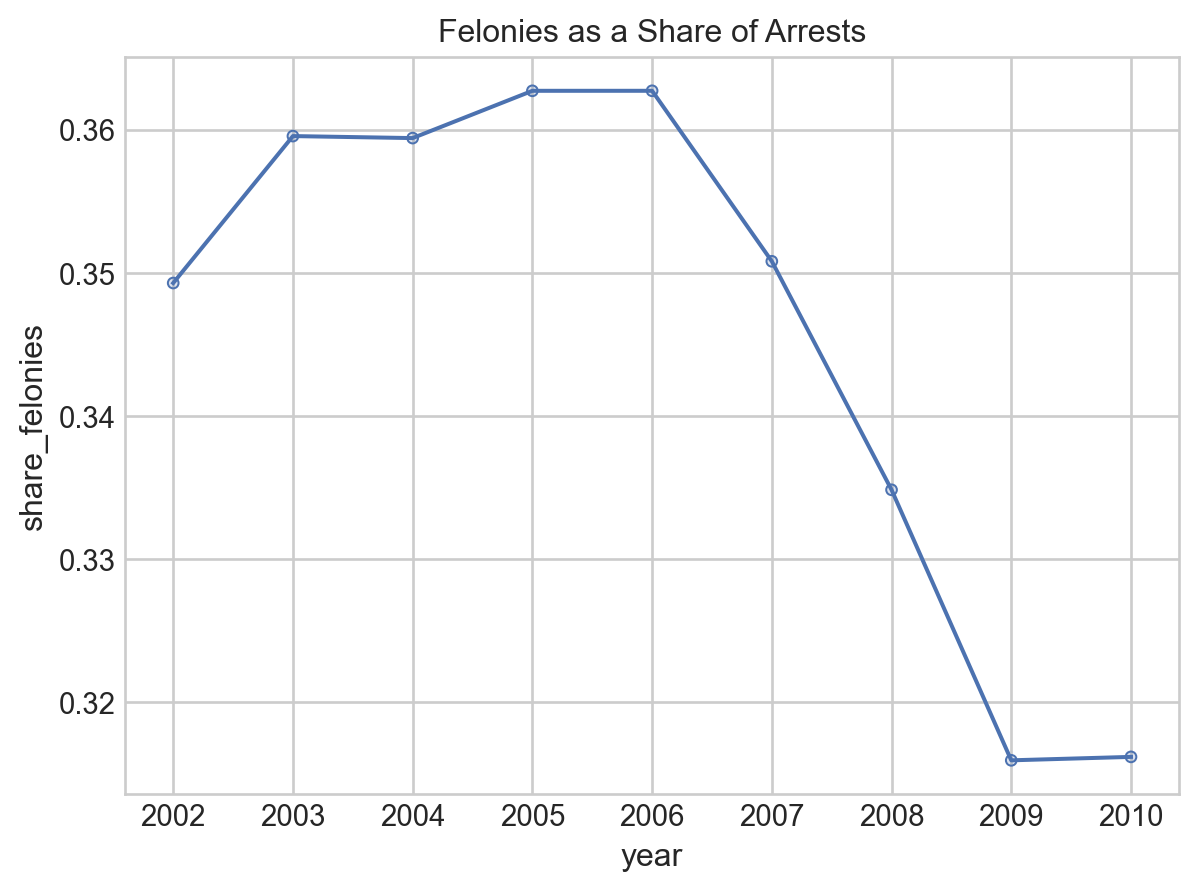

In [8]:
misdomeaners = pd.read_csv(
    "https://github.com/nickeubank/practicaldatascience/raw"
    "/dbc2199fcf7e6302cdd1ea2955dc378605b52659/Example_Data"
    "/ca_misdomeaners_2001_2010.csv"
)
merged = pd.merge(felonies, misdomeaners, on="year", validate="1:1")
merged["share_felonies"] = merged["felony_arrests"] / (
    merged["felony_arrests"] + merged["misdomeaner_arrests"]
)

import seaborn.objects as so
from matplotlib import style
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

(
    so.Plot(merged, x="year", y="share_felonies")
    .add(so.Dots())
    .add(so.Lines())
    .label(title="Felonies as a Share of Arrests")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

Cool! The share of arrests that were felonies were about flat in the early 2000s, then fall sharply in the late 2000s. Everything looks great, right?! Let's publish a paper!

But wait... didn't we say our data was form 2001 to 2010? Then why isn't there a point being plotted for 2001? Something seems...🐟 🐠 🐡. (Fishy, get it?!)

Let's look more closely at our data.

In [9]:
merged

,year,felony_arrests,misdomeaner_arrests,share_felonies
0,2001,472677,NaN,NaN
1,2002,487364,907990.0,0.349276
2,2003,507081,903249.0,0.359548
3,2004,522781,931782.0,0.359408
4,2005,538166,945562.0,0.362712
5,2006,534460,939046.0,0.362713
6,2007,523276,968408.0,0.350795
7,2008,499628,992588.0,0.334823
8,2009,466441,1010038.0,0.315914
9,2010,448552,970221.0,0.316155


Huh... ok weird. Missing data for 2001 in `misdomeaner_arrests`. Was that in the original data?

In [10]:
misdomeaners

,year,misdomeaner_arrests
0,2001.0,NaN
1,2002.0,907990.0
2,2003.0,903249.0
3,2004.0,931782.0
4,2005.0,945562.0
5,2006.0,939046.0
6,2007.0,968408.0
7,2008.0,992588.0
8,2009.0,1010038.0
9,2010.0,970221.0


Uh... well that's bad. Not only is there no data for 2001, but there's data for a row with no year?! That *clearly* can't be right. 

We better go check the source data for this table. Here's what I see when I go back to the CA Bureau of Justice Crime Statistics:

![Crime source data](images/source_crime_data.png)

Hmmm... so the original data says 907,990 is the entry for 2001, but in our table it says that's the value for 2002. You know what I think happened? When the data was transcribed, it was offset one row by accident:

![data spreadsheet](images/misdomeaner_spreadsheet.png)

Which means... the problem isn't just that I'm missing data from 2001. It means that **all** of my data is wrong, not just 2001! The real result is:

In [11]:
misdomeaners["year"] = misdomeaners["year"] - 1
misdomeaners.loc[misdomeaners["year"].isnull(), "year"] = 2010
misdomeaners = misdomeaners[misdomeaners["year"] != 2000]
misdomeaners

,year,misdomeaner_arrests
1,2001.0,907990.0
2,2002.0,903249.0
3,2003.0,931782.0
4,2004.0,945562.0
5,2005.0,939046.0
6,2006.0,968408.0
7,2007.0,992588.0
8,2008.0,1010038.0
9,2009.0,970221.0
10,2010.0,918279.0


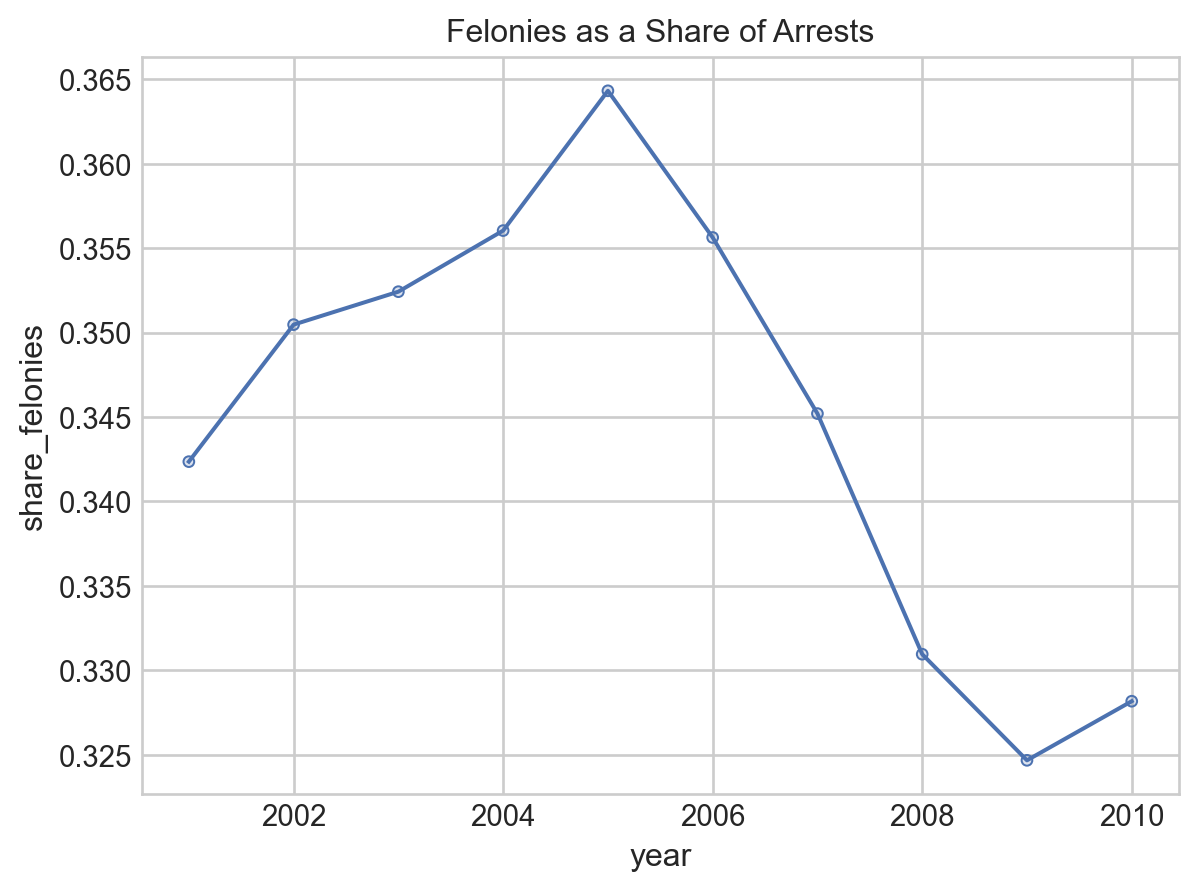

In [12]:
# This time I'll do an outer merge and check it!
merged = pd.merge(
    felonies, misdomeaners, on="year", validate="1:1", how="outer", indicator=True
)
assert (merged._merge == "both").all()
merged["share_felonies"] = merged["felony_arrests"] / (
    merged["felony_arrests"] + merged["misdomeaner_arrests"]
)

(
    so.Plot(merged, x="year", y="share_felonies")
    .add(so.Dots())
    .add(so.Lines())
    .label(title="Felonies as a Share of Arrests")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

Phew. OK, so the real answer is that there was a big increase in felonies as a share of total arrests in the early 2000s, then an even steeper decline than we saw before. 

And that, my friends, is the iceberg principle: often times very small anomylies in your data are the only warning you will get about much bigger problems, so you always want to keep an eye out for things you don't expect, and if you see something weird, *make sure you figure out why it's happening*, because while sometimes small problems are just small problems, other times your just seeing the tip of an iceberg:

![iceberg](images/iceberg.jpg)

And lest you think this is a contrived example: it's not. It is a simplified verison of a problem I encountered in my own research just 2 months ago, in which a single outlier observation lead me to realize that our data entry team had made an off-by-one error during data entry that had corrupted several years of data. I cannot tell you how many times over the years I've had this kind of thing occur -- I was one observation short in a regression, or I had one outlier, and when I dug into I discovered a much, much bigger problem. So *please* heed my warning: if you see something that seems off, no matter how small, figure out what's causing it!